# Iris dataset

Import the required libraries

In [1]:
# Data

from sklearn.datasets        import load_iris, make_moons
from sklearn.model_selection import train_test_split

# Visualization

import matplotlib.pyplot as plt

# ML model

import torch
import torch.nn    as nn
import torch.optim as optim

from torch_geometric.data   import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn     import MessagePassing
from torch_geometric.utils  import add_self_loops, degree



Basic neural network parameters

In [2]:
num_epochs    = 100
batch_size    = 16
learning_rate = 0.01

Load the Iris dataset

In [3]:
iris     = load_iris()
features = iris.data
labels   = iris.target

Split the dataset into training and testing sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

Convert the data to PyTorch tensors

In [5]:
X_train = torch.Tensor(X_train)
X_test  = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test  = torch.LongTensor(y_test)

Visualize the data

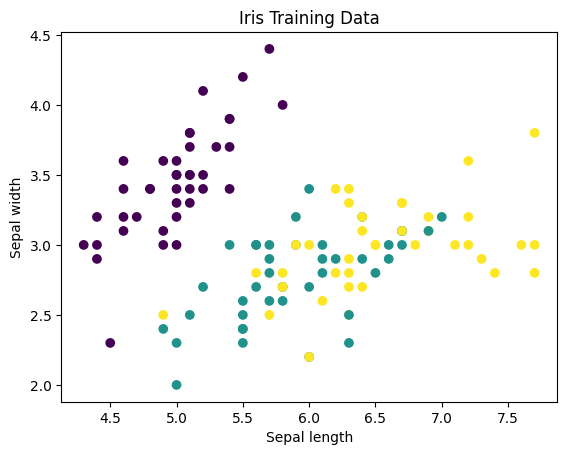

In [6]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Iris Training Data')
plt.show()

Define the neural network architecture

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 10)  # Fully connected layer 1
        self.fc2 = nn.Linear(10, 10)  # Fully connected layer 2
        self.fc3 = nn.Linear(10, 3)  # Output layer with 3 classes
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to fc1
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to fc2
        x = self.fc3(x)  # Output layer does not have an activation function
        return x

Create an instance of the neural network

In [8]:
model = NeuralNetwork()

Define the loss function and optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Training the neural network

In [10]:
losses = []
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        targets = y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    losses.append(loss.item())

Epoch: 10/100, Loss: 1.0496714115142822
Epoch: 20/100, Loss: 1.0068528652191162
Epoch: 30/100, Loss: 0.8816522359848022
Epoch: 40/100, Loss: 0.6907289624214172
Epoch: 50/100, Loss: 0.5640344023704529
Epoch: 60/100, Loss: 0.4994293451309204
Epoch: 70/100, Loss: 0.4483613073825836
Epoch: 80/100, Loss: 0.39420685172080994
Epoch: 90/100, Loss: 0.33759769797325134
Epoch: 100/100, Loss: 0.2766529619693756


Plot the loss curve

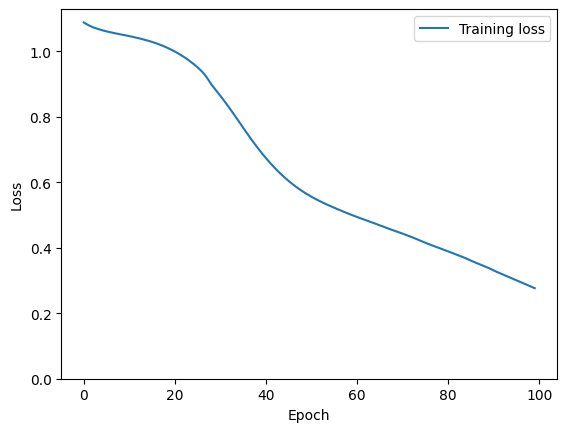

In [11]:
plt.plot(losses, label='Training loss')
plt.ylim(bottom=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

Evaluating the model

In [12]:
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f'Accuracy on test set: {accuracy}')

Accuracy on test set: 0.8666666666666667


# Make moons dataset

Import the required libraries

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch_geometric.data   import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn     import MessagePassing
from torch_geometric.utils  import add_self_loops, degree
from sklearn.datasets       import make_moons

import matplotlib.pyplot as plt

Basic neural network parameters

In [14]:
num_epochs    = 1000
batch_size    = 1
learning_rate = 0.01

Generate the example dataset

In [15]:
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

Convert the data to PyTorch tensors

In [16]:
X = torch.Tensor(X)
y = torch.Tensor(y)

Convert the data to a graph format

In [17]:
edge_index = torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0]], dtype=torch.long)
edge_attr = torch.tensor([1] * 32, dtype=torch.float)

data = Data(x=X, y=y, edge_index=edge_index, edge_attr=edge_attr)

Visualize the data

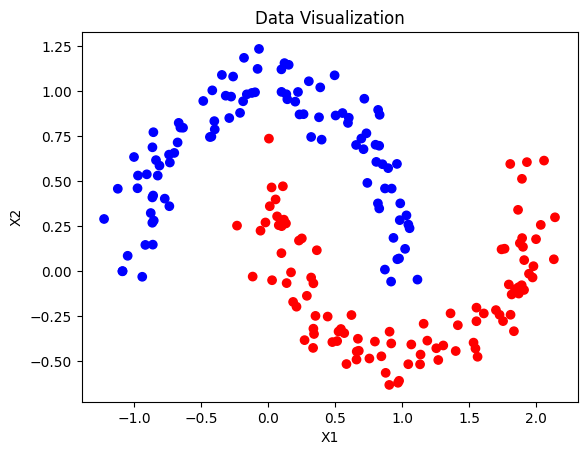

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Data Visualization')
plt.show()

Create a custom Graph Convolutional Layer

In [19]:
class GraphConvolution(MessagePassing):
    def __init__(self):
        super(GraphConvolution, self).__init__(aggr='add')

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        row, col = edge_index

        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

Create the CGNN model

In [20]:
class CGNN(nn.Module):
    def __init__(self):
        super(CGNN, self).__init__()
        self.conv1 = GraphConvolution()
        self.conv2 = GraphConvolution()
        self.fc = nn.Linear(2, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)

        return x.view(-1)

Create an instance of the CGNN model

In [21]:
model = CGNN()

Define the loss function and optimizer

In [22]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Create a DataLoader for batching the data

In [23]:
loader = DataLoader([data], batch_size=batch_size, shuffle=True)

Training the CGNN model

In [24]:
losses = []

for epoch in range(num_epochs):
    for batch in loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch: 10/1000, Loss: 0.37681156396865845
Epoch: 20/1000, Loss: 0.2957893908023834
Epoch: 30/1000, Loss: 0.2421393245458603
Epoch: 40/1000, Loss: 0.21064704656600952
Epoch: 50/1000, Loss: 0.19376255571842194
Epoch: 60/1000, Loss: 0.18443402647972107
Epoch: 70/1000, Loss: 0.17803333699703217
Epoch: 80/1000, Loss: 0.172477126121521
Epoch: 90/1000, Loss: 0.16722221672534943
Epoch: 100/1000, Loss: 0.162277951836586
Epoch: 110/1000, Loss: 0.15771879255771637
Epoch: 120/1000, Loss: 0.15357130765914917
Epoch: 130/1000, Loss: 0.1498308926820755
Epoch: 140/1000, Loss: 0.1464838832616806
Epoch: 150/1000, Loss: 0.1435130536556244
Epoch: 160/1000, Loss: 0.14089734852313995
Epoch: 170/1000, Loss: 0.1386120319366455
Epoch: 180/1000, Loss: 0.136630117893219
Epoch: 190/1000, Loss: 0.13492359220981598
Epoch: 200/1000, Loss: 0.13346442580223083
Epoch: 210/1000, Loss: 0.13222524523735046
Epoch: 220/1000, Loss: 0.13117997348308563
Epoch: 230/1000, Loss: 0.1303039789199829
Epoch: 240/1000, Loss: 0.12957461

Plot the loss curve

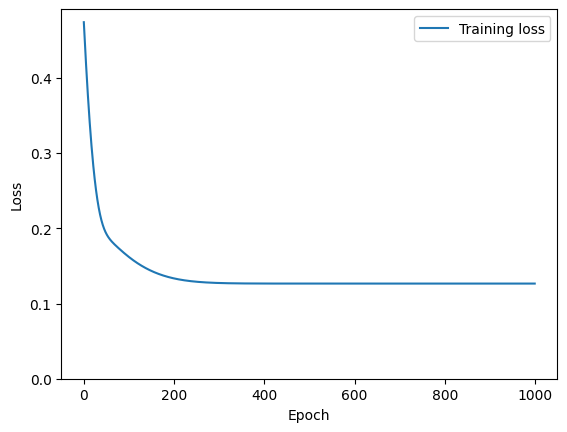

In [25]:
plt.plot(losses, label='Training loss')
plt.ylim(bottom=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

Visualize the predicted values

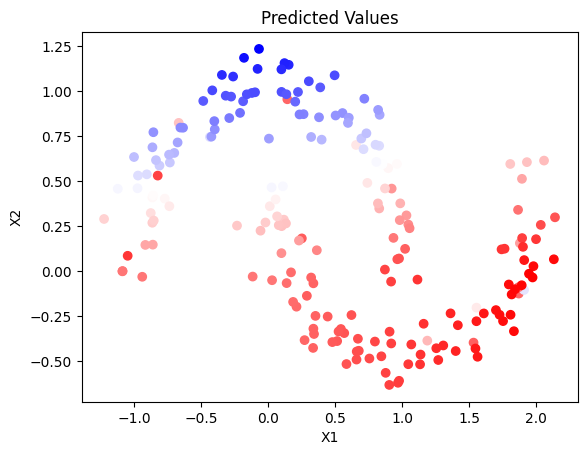

In [26]:
with torch.no_grad():
    predicted = model(data)

plt.scatter(X[:, 0], X[:, 1], c=predicted, cmap='bwr')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Predicted Values')
plt.show()

In [1]:
import ML_library        as ML
import matplotlib.pyplot as plt
import numpy             as np
import torch             as torch
import seaborn as sns

from os                     import path
from torch.utils.data       import random_split
from torch_geometric.loader import DataLoader
from torch_geometric.data   import Data

sns.set_theme()

In [2]:
n_epochs      = 100
batch_size    = 128
learning_rate = 0.0001
dropout       = 0.4

# Generation of graph database for training

### Loading dataset

Load the dataset. If it was already normalized, that dataset is loaded. Otherwise, we have to nomalized it (very time costly).

In [3]:
if path.exists('normalized_dataset.pt'):
    dataset = torch.load('normalized_dataset.pt')

else:
    dataset = torch.load('dataset.pt')
    
    ### Santadirizing properties
    
    # Compute means and standard deviations
    
    target_list = torch.tensor([])
    edge_list   = torch.tensor([])

    for data in dataset:
        target_list = torch.cat((target_list, data.y),         0)
        edge_list   = torch.cat((edge_list,   data.edge_attr), 0)

    scale = 1e0

    target_mean = torch.mean(target_list)
    target_std  = torch.std(target_list)

    edge_mean = torch.mean(edge_list)
    edge_std  = torch.std(edge_list)

    target_factor = target_std / scale
    edge_factor   = target_std / scale
    
    # Update normalized values into the database
    
    for data in dataset:
        data.y         = (data.y         - target_mean) / target_factor
        data.edge_attr = (data.edge_attr - edge_mean)   / edge_factor
    
    # Same for the node features
    
    feat_mean = torch.tensor([])
    feat_std  = torch.tensor([])

    for feat_index in range(dataset[0].num_node_features):
        feat_list = torch.tensor([])

        for data in dataset:
            feat_list = torch.cat((feat_list, data.x[:, feat_index]), 0)

        feat_mean = torch.cat((feat_mean, torch.tensor([torch.mean(feat_list)])), 0)
        feat_std  = torch.cat((feat_std,  torch.tensor([torch.std(feat_list)])),  0)

        for data in dataset:
            data.x[:, feat_index] = (data.x[:, feat_index] - feat_mean[feat_index]) * scale / feat_std[feat_index]
    
    torch.save(dataset, 'normalized_dataset.pt')

# Generation of Graph Neural Network model

Create train and test sets. If it is aimed to do hyperparameters optimization, a validation must be as well defined.

In [4]:
torch.manual_seed(12345)

# Define the sizes of the train and test sets
train_size = int(0.9 * len(dataset))
test_size  = len(dataset) - train_size

# Use random_split() to generate train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of testing  graphs: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=batch_size,        shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=True)

Number of training graphs: 23720
Number of testing  graphs: 2636


Initizalize the model. *num_node_features* extracts from one graph the number features defined for each atom.

In [5]:
model = ML.GCNN(features_channels=dataset[0].num_node_features,
                 pdropout=dropout)
print(model)

GCNN(
  (conv1): GraphConv(5, 256)
  (conv2): GraphConv(256, 256)
  (linconv): Linear(in_features=256, out_features=16, bias=True)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)


Epoch: 1, Train MAE: 3.1776, Test MAE: 0.9708


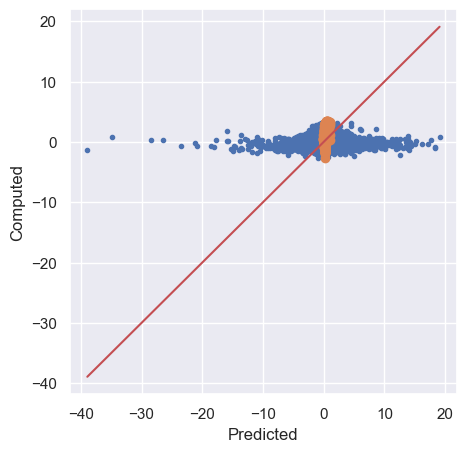

Epoch: 2, Train MAE: 0.8167, Test MAE: 0.6322
Epoch: 3, Train MAE: 0.6564, Test MAE: 0.5313
Epoch: 4, Train MAE: 0.5816, Test MAE: 0.4992
Epoch: 5, Train MAE: 0.5567, Test MAE: 0.4680
Epoch: 6, Train MAE: 0.5272, Test MAE: 0.4478
Epoch: 7, Train MAE: 0.5187, Test MAE: 0.4358
Epoch: 8, Train MAE: 0.4847, Test MAE: 0.4281
Epoch: 9, Train MAE: 0.4586, Test MAE: 0.4097
Epoch: 10, Train MAE: 0.4415, Test MAE: 0.3977
Epoch: 11, Train MAE: 0.4286, Test MAE: 0.3897


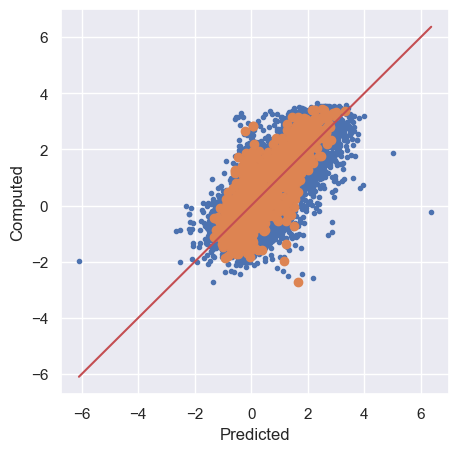

Epoch: 12, Train MAE: 0.4096, Test MAE: 0.3691
Epoch: 13, Train MAE: 0.3952, Test MAE: 0.3622
Epoch: 14, Train MAE: 0.3814, Test MAE: 0.3561
Epoch: 15, Train MAE: 0.3699, Test MAE: 0.3303
Epoch: 16, Train MAE: 0.3671, Test MAE: 0.3306
Epoch: 17, Train MAE: 0.3519, Test MAE: 0.3111
Epoch: 18, Train MAE: 0.3417, Test MAE: 0.3051
Epoch: 19, Train MAE: 0.3335, Test MAE: 0.2999
Epoch: 20, Train MAE: 0.3320, Test MAE: 0.2960
Epoch: 21, Train MAE: 0.3196, Test MAE: 0.2805


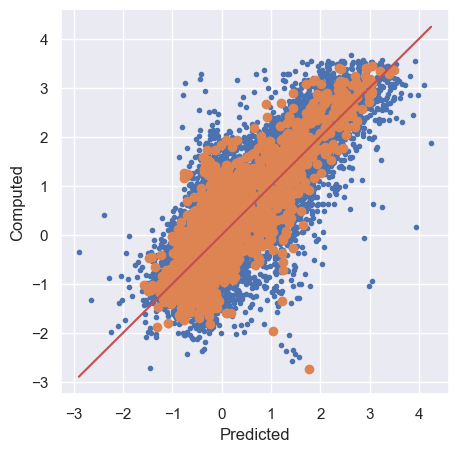

Epoch: 22, Train MAE: 0.3106, Test MAE: 0.2762
Epoch: 23, Train MAE: 0.3016, Test MAE: 0.2674
Epoch: 24, Train MAE: 0.2938, Test MAE: 0.2572
Epoch: 25, Train MAE: 0.2855, Test MAE: 0.2527
Epoch: 26, Train MAE: 0.2819, Test MAE: 0.2495
Epoch: 27, Train MAE: 0.2769, Test MAE: 0.2380
Epoch: 28, Train MAE: 0.2713, Test MAE: 0.2438
Epoch: 29, Train MAE: 0.2666, Test MAE: 0.2377
Epoch: 30, Train MAE: 0.2631, Test MAE: 0.2234
Epoch: 31, Train MAE: 0.2575, Test MAE: 0.2256


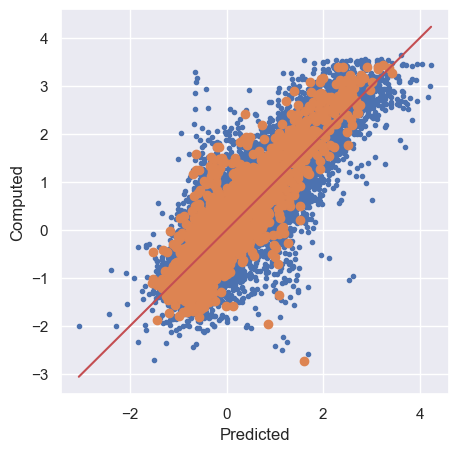

Epoch: 32, Train MAE: 0.2545, Test MAE: 0.2253
Epoch: 33, Train MAE: 0.2489, Test MAE: 0.2209
Epoch: 34, Train MAE: 0.2442, Test MAE: 0.2121
Epoch: 35, Train MAE: 0.2420, Test MAE: 0.2112
Epoch: 36, Train MAE: 0.2386, Test MAE: 0.2217
Epoch: 37, Train MAE: 0.2349, Test MAE: 0.2123
Epoch: 38, Train MAE: 0.2324, Test MAE: 0.2054
Epoch: 39, Train MAE: 0.2327, Test MAE: 0.2017
Epoch: 40, Train MAE: 0.2257, Test MAE: 0.1987
Epoch: 41, Train MAE: 0.2236, Test MAE: 0.1948


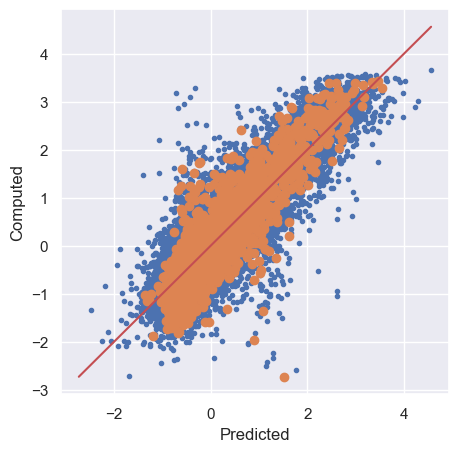

Epoch: 42, Train MAE: 0.2281, Test MAE: 0.1894
Epoch: 43, Train MAE: 0.2210, Test MAE: 0.1870
Epoch: 44, Train MAE: 0.2199, Test MAE: 0.1889
Epoch: 45, Train MAE: 0.2148, Test MAE: 0.1807
Epoch: 46, Train MAE: 0.2157, Test MAE: 0.1911
Epoch: 47, Train MAE: 0.2097, Test MAE: 0.1764
Epoch: 48, Train MAE: 0.2113, Test MAE: 0.1821
Epoch: 49, Train MAE: 0.2068, Test MAE: 0.1843
Epoch: 50, Train MAE: 0.2063, Test MAE: 0.1802
Epoch: 51, Train MAE: 0.2047, Test MAE: 0.1721


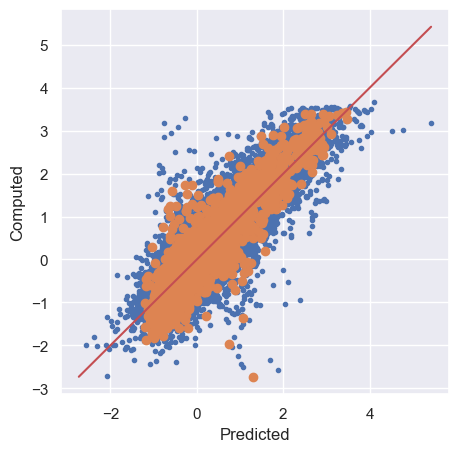

Epoch: 52, Train MAE: 0.2015, Test MAE: 0.1714
Epoch: 53, Train MAE: 0.2007, Test MAE: 0.1690
Epoch: 54, Train MAE: 0.1980, Test MAE: 0.1734
Epoch: 55, Train MAE: 0.1968, Test MAE: 0.1771
Epoch: 56, Train MAE: 0.1943, Test MAE: 0.1662
Epoch: 57, Train MAE: 0.1955, Test MAE: 0.1701
Epoch: 58, Train MAE: 0.1914, Test MAE: 0.1617
Epoch: 59, Train MAE: 0.1921, Test MAE: 0.1613
Epoch: 60, Train MAE: 0.1901, Test MAE: 0.1566
Epoch: 61, Train MAE: 0.1880, Test MAE: 0.1627


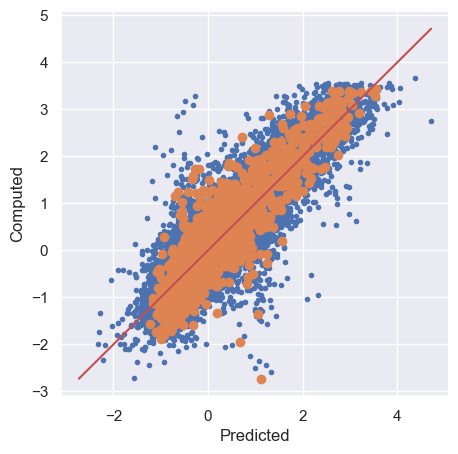

Epoch: 62, Train MAE: 0.1864, Test MAE: 0.1571
Epoch: 63, Train MAE: 0.1841, Test MAE: 0.1547
Epoch: 64, Train MAE: 0.1833, Test MAE: 0.1553
Epoch: 65, Train MAE: 0.1825, Test MAE: 0.1537
Epoch: 66, Train MAE: 0.1788, Test MAE: 0.1588
Epoch: 67, Train MAE: 0.1796, Test MAE: 0.1581
Epoch: 68, Train MAE: 0.1805, Test MAE: 0.1505
Epoch: 69, Train MAE: 0.1824, Test MAE: 0.1497
Epoch: 70, Train MAE: 0.1782, Test MAE: 0.1549
Epoch: 71, Train MAE: 0.1727, Test MAE: 0.1486


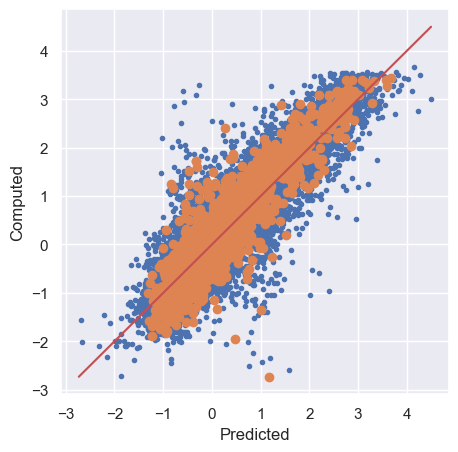

Epoch: 72, Train MAE: 0.1745, Test MAE: 0.1461
Epoch: 73, Train MAE: 0.1738, Test MAE: 0.1473
Epoch: 74, Train MAE: 0.1727, Test MAE: 0.1462
Epoch: 75, Train MAE: 0.1710, Test MAE: 0.1492
Epoch: 76, Train MAE: 0.1710, Test MAE: 0.1474
Epoch: 77, Train MAE: 0.1688, Test MAE: 0.1486
Epoch: 78, Train MAE: 0.1691, Test MAE: 0.1445
Epoch: 79, Train MAE: 0.1718, Test MAE: 0.1477
Epoch: 80, Train MAE: 0.1695, Test MAE: 0.1445
Epoch: 81, Train MAE: 0.1677, Test MAE: 0.1476


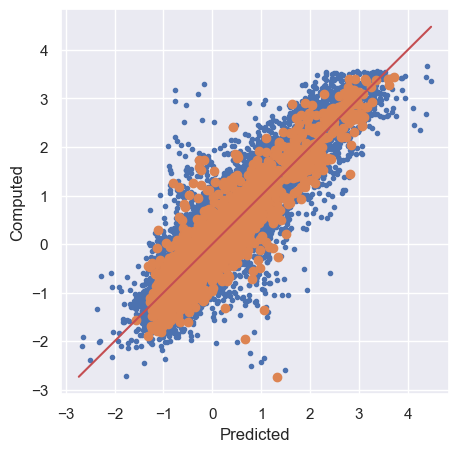

Epoch: 82, Train MAE: 0.1657, Test MAE: 0.1441
Epoch: 83, Train MAE: 0.1662, Test MAE: 0.1448
Epoch: 84, Train MAE: 0.1680, Test MAE: 0.1426
Epoch: 85, Train MAE: 0.1669, Test MAE: 0.1441
Epoch: 86, Train MAE: 0.1654, Test MAE: 0.1388
Epoch: 87, Train MAE: 0.1635, Test MAE: 0.1408
Epoch: 88, Train MAE: 0.1623, Test MAE: 0.1398
Epoch: 89, Train MAE: 0.1648, Test MAE: 0.1399
Epoch: 90, Train MAE: 0.1636, Test MAE: 0.1401
Epoch: 91, Train MAE: 0.1612, Test MAE: 0.1420


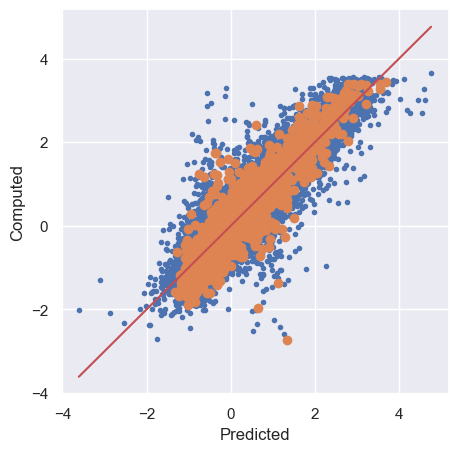

Epoch: 92, Train MAE: 0.1589, Test MAE: 0.1388
Epoch: 93, Train MAE: 0.1605, Test MAE: 0.1382
Epoch: 94, Train MAE: 0.1581, Test MAE: 0.1394
Epoch: 95, Train MAE: 0.1590, Test MAE: 0.1389
Epoch: 96, Train MAE: 0.1591, Test MAE: 0.1343
Epoch: 97, Train MAE: 0.1579, Test MAE: 0.1364
Epoch: 98, Train MAE: 0.1552, Test MAE: 0.1324
Epoch: 99, Train MAE: 0.1557, Test MAE: 0.1477
Epoch: 100, Train MAE: 0.1562, Test MAE: 0.1345


In [6]:
# Define basic properties
# MSELoss is by default defined as the mean within the batch
# Thus, every batch contributes the same to the loss regardless of their shape (might be somenthing to change)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize all lists for extracting training results and train the model

train_losses = []
test_losses  = []
for epoch in range(n_epochs):
    train_loss, train_predictions, train_ground_truths = ML.train(model, criterion, train_loader, optimizer)
    test_loss,  test_predictions,  test_ground_truths  =  ML.test(model, criterion, test_loader)
    
    # Append losses
    train_losses.append(train_loss)
    test_losses.append(test_loss)
      
    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Test MAE: {test_loss:.4f}')
    
    if epoch % 10 == 0:
        stack = np.concatenate([train_predictions, train_ground_truths,
                                test_predictions,  test_ground_truths])

        _min_ = np.min(stack)
        _max_ = np.max(stack)

        plt.figure(figsize=(5, 5))
        plt.plot(train_predictions, train_ground_truths, '.', label='Train set')
        plt.plot(test_predictions,  test_ground_truths,  'o', label='Test  set')
        plt.xlabel(f'Predicted')
        plt.ylabel(f'Computed')
        plt.plot([_min_, _max_], [_min_, _max_], '-r')
        plt.show()

Plotting loss function

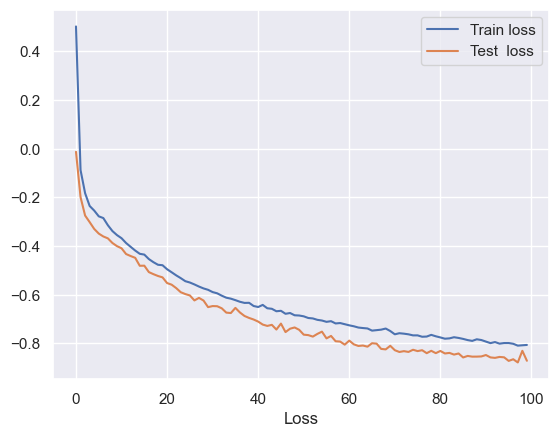

In [7]:
plt.plot(np.log10(train_losses), label='Train loss')
plt.plot(np.log10(test_losses) , label='Test  loss')
plt.xlabel('Epoch')
plt.xlabel('Loss')
plt.legend(loc='best')
plt.show()